# Visualization and inspection
* Visualize importances, globally, locally.
* Trace influential variables to geographic locations by mapping importance
* Plot fields for important variables at moments in time
* Scatter influential variables against y
* Plot shap contributions to y = f(x)

In [1]:
import sys
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
#import shap
from scipy.signal import detrend
from pathlib import Path

sys.path.append(os.path.expanduser('~/Documents/Weave'))
from Weave.utils import collapse_restore_multiindex, get_nhplus, get_nhmin, get_europe
from Weave.models import HybridExceedenceModel

from Weave.inspection import ImportanceData, MapInterface, data_for_shapplot, yplot, dotplot, barplot, mapplot, scatterplot, in_out_kept
#logging.basicConfig(level = logging.DEBUG)
#shap.initjs()

In [4]:
basepath = Path('/nobackup_1/users/straaten/')
#basepath = Path('/scistor/ivm/jsn295/')
# Latest results:
quantile = 0.666 # options: 0.666 and 0.8
permimppath = basepath / f'permimp_val_q0{str(quantile)[2:]}'
shappath = basepath / f'shap_stdback_train_q0{str(quantile)[2:]}'
#shappath = basepath / f'shap_pathdep_val_q0{str(quantile)[2:]}'
inputpath = basepath / 'clusters_cv_spearmanpar_varalpha_strict' # Latest dimreduced X and y data 
anompath = basepath / 'processed'

shapvalpath = basepath / f'shap_stdback_val_q0{str(quantile)[2:]}'
shaptrainpath = basepath / f'shap_stdback_train_q0{str(quantile)[2:]}'
permvalpath = basepath / f'permimp_val_q0{str(quantile)[2:]}'
permtrainpath = basepath / f'permimp_train_q0{str(quantile)[2:]}'

model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)

## comparing computation on_val with on_train
We suspect that especially for non-stationary variables this makes a difference. (Especially affecting folds 3 and 4 when it is climate change, if multi-decadal then all folds equally). With non-stionarity one expects that the model will perform worse. The factor was fitted in training, by being outside the range in validation it influences predictions unwanted.
* Potentially this increases its shap value in the validation data. The combined effect of its importance in training and non-stationarity. So should also have reasonable shap in train.
* Because it makes the model worse, permuting it will not degrade the model a lot further, in other words the variable becomes unimportant, even though it has affected everything. One would expect a great drop in singlepass importance from train to val.
* For both shap and permimp we expect that unimportant non-stationary variables are low in both validation and training fold. (Unless you get weird extrapolation effects from the important non-stationary variables)

What is the effect on our plotting capabilities:
* We can still plot global importance for the regions per fold (only then in its training period)
* for the local importance we suddenly have the datapoint in different folds (with differing clusters)

How could we remove a fold dimension?
* Clipping away cells that do not occur in at least X of the 5 folds
* Then averaging the importance values.
* Probably should be done in the map to fields.

In [10]:
respagg = 11
separation = [-7,-3]
#shapval = ImportanceData(shapvalpath, respagg, separation, quantile, model)
#shapval.load_data(inputpath=inputpath, X_too = True, y_too = True)
shaptrain = ImportanceData(shaptrainpath, respagg, separation, quantile, model)
shaptrain.load_data(inputpath=inputpath, X_too = True, y_too = True)
#permval = ImportanceData(permvalpath, respagg, separation, quantile, model)
#permval.load_data(inputpath=inputpath, X_too = True, y_too = True)
permtrain = ImportanceData(permtrainpath, respagg, separation, quantile, model)
permtrain.load_data(inputpath=inputpath, X_too = True, y_too = True)

In [23]:
permtrain.scale_within(fill_na = True)
#permval.scale_within(fill_na = True)
#shapval.global_shap()
shaptrain.global_shap()

In [33]:
base = permtrain.df.loc[:,('singlepass','score')].unstack('fold')
other = permval.df.loc[:,('singlepass','score')].unstack('fold')
new, out, kept = in_out_kept(base, other, ignore_in_names=['respagg','lag','separation'])

In [34]:
new

fold,0,1,2,3,4
other_imp,,,,,
1,sst_nhplus.21.2.mean,NaN,NaN,NaN,NaN
2,tcc_europe.31.0.spatcov,NaN,NaN,swvl13_europe.21.0.spatcov,sst_nhplus.31.0.mean
3,t850_nhblock.31.0.spatcov,tcc_europe.31.1.spatcov,NaN,NaN,sst_nhplus.11.1.spatcov
4,siconc_nhmin.21.0.spatcov,siconc_nhmin.15.1.mean,t850_nhblock.21.0.mean,NaN,sst_nhplus.11.3.mean
5,t850_nhblock.21.1.mean,swvl13_europe.15.0.mean,swvl4_europe.31.0.spatcov,snowc_nhmin.21.2.spatcov,swvl13_europe.11.2.spatcov
6,tcc_europe.15.0.spatcov,transp_europe.31.2.spatcov,NaN,siconc_nhmin.15.2.mean,sst_nhplus.11.2.mean
7,snowc_nhmin.31.2.spatcov,sst_nhplus.11.5.spatcov,sst_nhplus.15.3.mean,swvl13_europe.31.0.spatcov,sst_nhplus.15.7.spatcov
8,NaN,NaN,sst_nhplus.11.0.spatcov,sst_nhplus.7.0.mean,siconc_nhmin.31.0.spatcov


Within Training the multipass and singlepass are remarkably consistent. Weird since multipass was designed to accomodate for information redundancy when two predictors are colinear (making both unimportant). This should mean that colinearity is less of an issue. Or that the fitting has been so random that the information was divided anyway over the models.

When going from training to validation you see for singlepass a lot of difference. Also the raw BS values in validation become less differentiated from each other (this is less visible after the scaling), basically because the model always has trouble. 
Luckily for instance to top predictor in training is also in the validation selection. (except for fold 1 and 0). Around 2-5 predictors are kept. This disappearing important ones are thus non-stationary I guess. And it should according to the expectation not drop out at shap-val (and it multipass it should also disappear.)

When going from training to validation with multipass, about 2-6 predictors are kept. Meaning slightly less new enter than in singlepass. These kept variables appear similar to singlepass. Looking at the new ones entering (in training unimportant) there is less corresponding with the ones entering in singlepass. 

Indeed the shap from train to val is also very consistent. Some values are slightly enlarged or lessened and order can change a bit. But hardly any new variables enter.

## Amount of input clusters
Independent of the response aggregation. Just dependent on the moment in time before the separation starts.

In [5]:
Xin = pd.read_parquet(inputpath / 'precursor.multiagg.parquet') # All are double because both spatcov and mean was extracted
Xin = Xin.loc[:, Xin.columns.get_loc_level('spatcov','metric')[0]].iloc[-1,:] # Only one timeslice needed.

In [6]:
groups = list(Xin.index.names)
groups.remove('clustid')
counts = Xin.groupby(groups).count()
# neccessary for the new cv-approach. To average over folds
groups.remove('fold')
counts = counts.groupby(groups).mean()
counts.index = pd.MultiIndex.from_frame(counts.index.to_frame().assign(respagg = 7)) # To make sure that a unique respagg is present such that non-unique separation becomes the x-var 
counts.name = 'mean_number_of_clusters_over_folds'
counts.loc[:,:] = 4

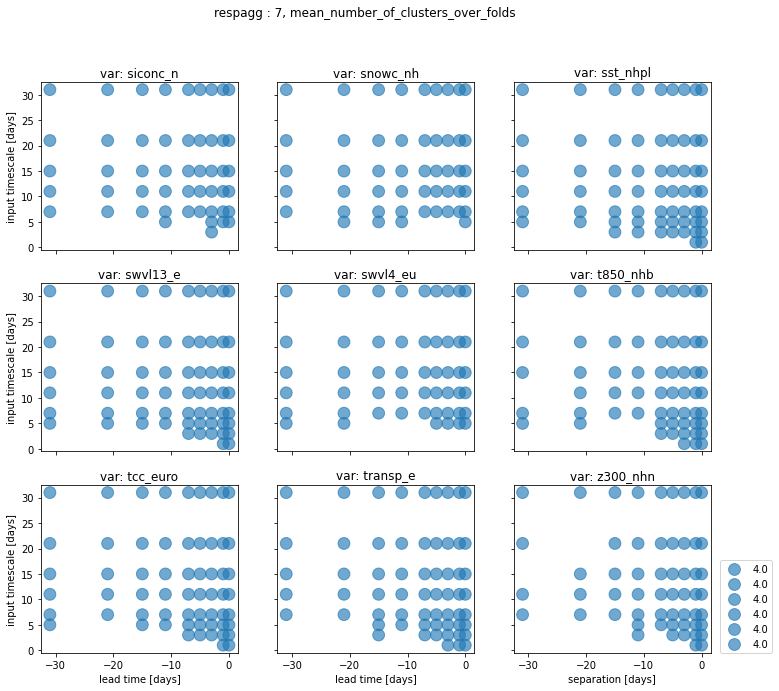

In [10]:
#fig, axes = dotplot(counts, alphascaler = 0.15, nlegend_items=6, sizescaler=50, color = 'tab:blue')
fig, axes = dotplot(counts, alphascaler = 0.16, nlegend_items=6, sizescaler=35, color = 'tab:blue', marker = 'o')
axes[-1,0].set_xlabel('lead time [days]')
axes[-1,1].set_xlabel('lead time [days]')
axes[-1,1].set_xlabel('lead time [days]')
#fig, axes = dotplot(counts, fig = fig, axes = axes, alphascaler = 0.15, nlegend_items=6, sizescaler=10, color = 'tab:red')
plt.savefig('/usr/people/straaten/Pictures/signif.pdf')

## Importance of input

In [11]:
respagg_of_interest = [7,31] # [0,1,3,5,7,11,15,21,31]
separation_of_interest = [0,-1,-3,-5,-7,-11,-15,-21,-31] # -15
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)

In [12]:
shaps = ImportanceData(shaptrainpath, respagg=respagg_of_interest, separation= separation_of_interest, quantile = quantile, model=model)
shaps.load_data(inputpath=inputpath, X_too = True, y_too = True)
shaps.global_shap() # Reduces the column (time) axis.
shaps.reduce_over('metric', how = 'max')
shaps.reduce_over('clustid', how = 'mean') # Now max and or sum are doable (we have made absolute the large negative probabilistic influences)
shaps.reduce_over('fold', how = 'mean') # Reduce over the folds.
shaps.df = shaps.df * 100
shaps.df.iloc[(shaps.df.iloc[:,0] < 0.5).values,:] = 0

In [13]:
permimps = ImportanceData(permtrainpath, respagg=respagg_of_interest, separation= separation_of_interest, quantile = quantile, model=model)
permimps.load_data(inputpath = inputpath, X_too = True, y_too = True)
permimps.scale_within(fill_na = True) # This scales within ['respagg','separation','fold'], so gets one model fit onto scale [0,1]
permimps.reduce_over('clustid', how = 'max') # Max does not equal sum here. Though it is similar in character (there are no negative importances)
permimps.reduce_over('metric', how = 'max')
#perm.df = perm.df.iloc[perm.df.index.get_loc_level('spatcov',level = 'metric')[0],:] # Selecting only one metric
permimps.reduce_over('fold', how = 'mean') # Mean equals sum here because the amount of folds is equal.

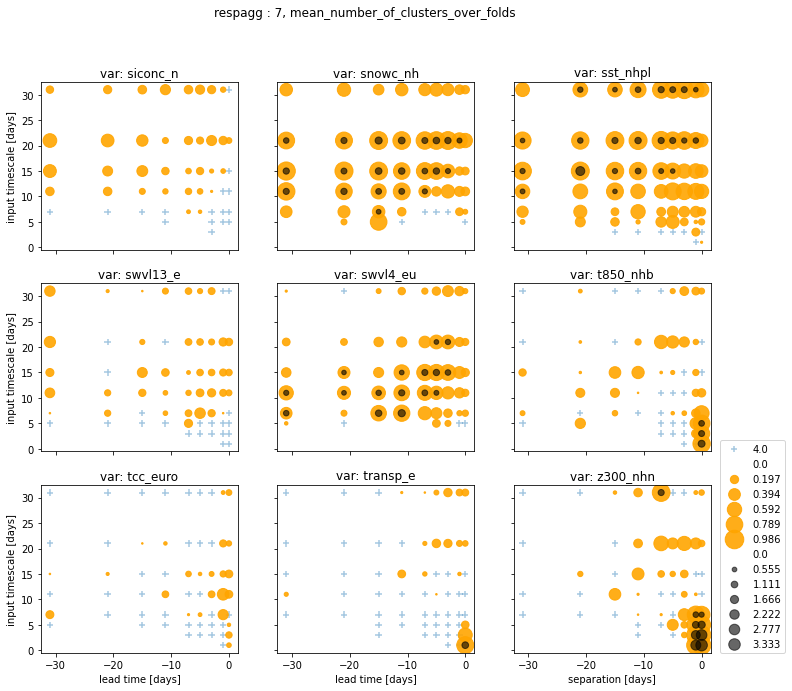

In [55]:
respagg = 7
shappies = shaps.df.loc[[respagg]].iloc[:,0]
multiperm = permimps.df.loc[[respagg],:].iloc[:,2]
counts2 = counts.copy()
counts2.index = counts2.index.droplevel([-2,-1]) # Drop the wrong respagg
not_used = counts2.reindex(multiperm.iloc[multiperm.values == 0].index.droplevel(0)) # No multipass value, so certainly also no significant shap value
not_used.index = pd.MultiIndex.from_frame(not_used.index.to_frame().assign(respagg = respagg))
fig, axes = dotplot(not_used, alphascaler = 0.1, nlegend_items=1, sizescaler=10, color = 'tab:blue', marker = '+')
fig, axes = dotplot(multiperm, fig = fig, axes = axes, fix_alpha = 0.9, sizescaler=350,nlegend_items=6, color ='orange')
fig, axes = dotplot(shappies, fig = fig, axes = axes, fix_alpha = 0.6, sizescaler=40, nlegend_items=7, color ='black')
#fig, axes = dotplot(permimps.df.loc[[31],:].iloc[:,2], fig = fig, axes = axes, alphascaler = 0.8, sizescaler=350,nlegend_items=6, color ='tab:orange')
#fig, axes = dotplot(shaps.df.loc[[31]].iloc[:,0], fig = fig, axes = axes, alphascaler = 25, sizescaler=4000, nlegend_items=6, color ='black')
axes[-1,0].set_xlabel('lead time [days]')
axes[-1,1].set_xlabel('lead time [days]')
axes[-1,1].set_xlabel('lead time [days]')
plt.savefig(f'/usr/people/straaten/Pictures/Importance_{respagg}.pdf')

## Testing scatterplot of X vs y

In [23]:
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
shaps = ImportanceData(shappath, respagg=31, separation= [-15], quantile = quantile, model=model)
shaps.load_data(inputpath = inputpath, y_too=True)
shaps.global_shap() # Reduces the column axis. Just to determine which is the most important

(<Figure size 360x360 with 1 Axes>,
 array([[<AxesSubplot:title={'center':'validation: 1981-06-01 - 1988-08-31, imp: 0.066'}, xlabel="(3, 'sst_nhplus', 31, -46, -15, 1, 'spatcov')", ylabel='response agg: 31'>]],
       dtype=object))

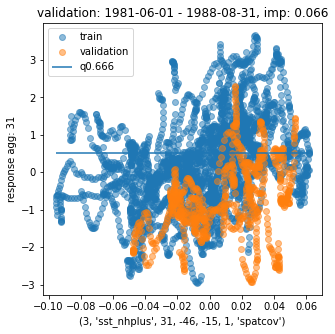

In [33]:
scatterplot(shaps, shaps.df.loc[(31,[3]),:].iloc[[shaps.df.loc[(31,[3]),:].iloc[:,0].argmax()],:], quantile = quantile)

This most important factor is supported by global shap both in training and in validation. It is interesting that with this trended response you see the validation fold have a clear vertical position depending on the timing of the validation fold (now the first, so lowest).

## Y-response plots and contributions for case

In [4]:
quantile = 0.666
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 7, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
shaps = ImportanceData(shapvalpath, respagg=[31], separation= [-15], quantile = quantile, model=model)
shaps.load_data(X_too = True, y_too = True, inputpath = inputpath)

In [35]:
preds = shaps.get_predictions(when = shaps.y.columns, respagg = 31, separation = -15)

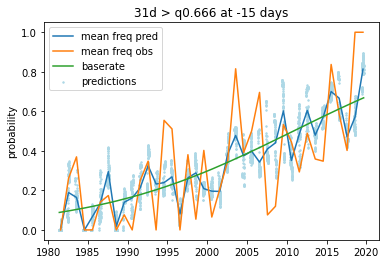

In [60]:
obs = shaps.get_exceedences(when = shaps.y.columns, respagg = 31)
base = shaps.get_baserate(when = shaps.y.columns, respagg = 31)
mean_freq = obs.groupby(obs.index.year).mean()
mean_freq.index = pd.date_range('1981',periods = len(mean_freq), freq = 'A-JUL' )
mean_pred = preds.groupby(preds.index.year).mean()
mean_pred.index = pd.date_range('1981',periods = len(mean_pred), freq = 'A-JUL' )
fig, ax = plt.subplots()
ax.scatter(preds.index, preds.values, s = 2, alpha = 1, label = 'predictions', color = 'lightblue')
ax.set_title('31d > q0.666 at -15 days')
ax.set_ylabel('probability')
ax.plot(mean_pred, label = 'mean freq pred')
ax.plot(mean_freq, label = 'mean freq obs')
ax.plot(base, label = 'baserate')
ax.legend(loc = 'upper left')

Fitting multiple models. And seeing for a case (now summer 2010) how the y response prediction is update from responseagg to responseagg or from separation to separation.

In [26]:
summer = '2015'
moment1 = pd.Timestamp(f'{summer}-06-06')
moment2 = pd.Timestamp(f'{summer}-07-16')

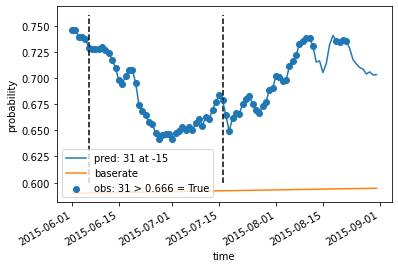

In [27]:
fig, ax = yplot(shaps, resp_sep_combinations = [(31,-15)], startdate = f'{summer}-06-01', enddate = f'{summer}-09-01')
baserate = shaps.get_baserate(when = pd.DatetimeIndex(pd.date_range(f'{summer}-06-01',f'{summer}-08-31')),respagg = 31)
ax.plot(baserate.index.values, baserate.values, label = 'baserate')
ax.legend(loc = 'lower left')
ax.vlines(x = [moment1,moment2], ymin= 0.6, ymax = 0.76, color = 'black', linestyle = 'dashed')
fig.autofmt_xdate()
plt.show()

For a specific slice or even timestamp the contributions of the input to the prediction can be plotted. Because: 'what led to updated prediction, or to the shift?' In the base the probability is not very high, even as late as the last decades. (0.2 on average for the 0.8 quantile)